# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [34]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here
def getK (X,Y,kernel,par) :
  #X = np.float96(X)
  #Y = np.float96(Y)
  if kernel == 'linear':
    return X @ Y.T
  if kernel == 'poly':
    temp = np.matmul(X , Y.T)
    return np.power((1+temp),par)
  if kernel == 'rbf':
    X_norm = np.sum(np.power(X,2), axis = -1)
    Y_norm = np.sum(np.power(Y,2), axis = -1)
    K = np.exp(-par * (X_norm[:,None] + Y_norm[None,:] - 2 * np.dot(X, Y.T)))
    return K
  assert False, "Unknown Kernel"

def sigma(x) :
  return np.exp(-np.logaddexp(0, -x))


def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., 
                                   kernel_param=1., num_iter_gd=200):
    # """
    # Arguments:
    # X : (n,d) shape numpy array
    # Y : (n,)  shape numpy array
    # X_test : (m,d) shape numpy array
    # kernel = 'linear' or 'rbf' or 'poly' 
    # reg_param = $\lambda$
    # num_iter_gd = number of GD iterations.

    # Returns the result of kernel logistic regression :
    # alpha: Vector of solutions for the dual. Numpy array of shape (n,)

    # Primal problem:
    # $ \min_w  \sum_{i=1}^n \log(1+\exp(-y_i* \w^\top \phi(\x_i)))  + \frac{\lambda}{2} ||\w||^2 $

    # the dual of which is

    # $ \min_alpha \sum_{i=1}^n \log(1+\exp(-y_i* \alpha^\top K_{:,i} ))  + \frac{\lambda}{2} \alpha^\top K \alpha $
    # where $\phi$ is the feature got by the kernel.

    # Where K is the nxn kernel matrix computed on the training data.

    # The kernel is defined by the kernel_param:
    # If kernel=linear: K(\u,\v) = \u^\top \v  
    # If kernel=poly:  K(\u,\v) = (1+\u^\top \v)^(kernel_param)
    # If kernel=rbf:  K(\u,\v) = \exp(-kernel_param*||\u-\v||^2)
    # """
    n = len(X)
    alpha = np.zeros(n)
    mean = np.mean(X, axis = 0)
    X = X - mean
    std_dev = np.std(X, axis = 0)
    if std_dev.all() > 0:
      X /= std_dev
    K = getK(X,X,kernel,kernel_param)
    eta = 0.0001*700
    term = -(K * Y)
    #prev_risk = 1e18
    if kernel == 'rbf':
      factor = 2
    for i in range(num_iter_gd) :
      arg = -((K @ alpha) * Y)
      multiplier = sigma(arg)
      reg_term = reg_param*(K @ alpha)
      grad = np.sum(term*multiplier, axis = 1) + reg_term
      #grad /= n
      modgrad = np.linalg.norm(grad)
      if modgrad >=1:
        grad /= modgrad
      init_alpha = alpha
      alpha = alpha - eta*grad
      #1 = np.sum(np.logaddexp(0,arg))
      #t2 = (alpha.T @ (reg_term/2))
      #risk= t1 + t2
      if i%10 == 0:
        eta *= 0.9 
     # prev_risk = risk
    return alpha

def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    m = len(test_X)
    n = len(train_X)
    mean = np.mean(train_X, axis = 0)
    train_X = train_X - mean
    test_X = test_X - mean
    std_dev = np.std(train_X, axis = 0)
    if std_dev.all() > 0:
      train_X /= std_dev
      test_X /= std_dev
    Y = np.zeros((m,1))
    K = getK(train_X,test_X,kernel,kernel_param)
    alpha = alpha.reshape((alpha.shape[0], 1))
    calc = np.sum(K*alpha, axis = 0) 
    #print(calc.shape, Y.shape)
    Y = np.sign(calc)
    return Y



In [36]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below.
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180 
Data_Path = '../../Data/'
indtoa = ['A', 'B', 'C', 'D']
X_train = dict()
Y_train = dict()
X_test  = dict()
Y_test  = dict()
X_valid = dict()
Y_valid = dict()
kernel_params = []
kernel_paramp = [1,2,3,4,5,6,7]
#kernel_paramp = [2,3,4]
kernel_paramr = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
reg_params = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
#reg_params = [1e-3, 1e-2, 10]
#reg_params.reverse()
kernels = ['linear', 'poly', 'rbf']
#kernels = ['poly']
ke = len(kernels)
best_kernel_params = np.zeros((4,ke))
best_reg_params = np.zeros((4,ke))
train_error = np.zeros((4,ke))
test_error = np.zeros((4,ke))
train_frac = 0.8
psize = 7
alphas = {}
for index in range(4):
  data = np.load(Data_Path + f"dataset_{indtoa[index]}.npz")
  lst = data.files
  X_train[index] = data[lst[0]]
  Y_train[index] = data[lst[1]]
  X_test[index] = data[lst[2]]
  Y_test[index] = data[lst[3]]
  n = X_train[index].shape[0]
  num_train = int(n*train_frac)
  X_valid[index] = X_train[index][num_train:]
  Y_valid[index] = Y_train[index][num_train:]
  X_train[index] = X_train[index][:num_train]
  Y_train[index] = Y_train[index][:num_train]
  for k, kernel in enumerate(kernels):
    if kernel == 'poly':
      kernel_params = kernel_paramp
    else: 
      kernel_params = kernel_paramr
    validation_error = np.zeros((psize,psize))
    for i, kernel_param in enumerate(kernel_params):
      for j, reg_param in enumerate(reg_params):
        alpha = train_pred_logistic_regression(X_train[index], Y_train[index], kernel, reg_param, kernel_param)
        Y_pred = test_pred(alpha, X_train[index], Y_train[index], X_valid[index], kernel, kernel_param)
        validation_error[i][j] = np.sum(Y_pred != Y_valid[index])/Y_valid[index].shape[0]
    l,m = np.unravel_index(validation_error.argmin(), validation_error.shape)
    best_ker = kernel_params[l]
    best_reg = reg_params[m]
    alpha = train_pred_logistic_regression(X_train[index], Y_train[index], kernel, best_reg, best_ker)
    alphas[(index,k)] = alpha
    Y_pred = test_pred(alpha, X_train[index], Y_train[index], X_train[index], kernel, best_ker)
    train_error[index][k] = np.sum(Y_pred != Y_train[index])/Y_train[index].shape[0]
    Y_pred = test_pred(alpha, X_train[index], Y_train[index], X_test[index], kernel, best_ker)
    test_error[index][k] = np.sum(Y_pred != Y_test[index])/Y_test[index].shape[0]
    best_kernel_params[index][k] = best_ker
    best_reg_params[index][k] = best_reg
    #print(indtoa[index], kernel)
    #print(validation_error)
print(train_error)
print(test_error)
print(best_kernel_params)
print(best_reg_params)

#import pandas as pd 
#pd.DataFrame(B.round(7)).to_csv("bv.csv")



[[0.125      0.00166667 0.        ]
 [0.18       0.17833333 0.16916667]
 [0.06916667 0.         0.        ]
 [0.025      0.040625   0.        ]]
[[0.128      0.004      0.002     ]
 [0.198      0.206      0.196     ]
 [0.13131313 0.03367003 0.03367003]
 [0.03550296 0.04733728 0.04142012]]
[[1.e-03 3.e+00 1.e+00]
 [1.e-03 2.e+00 1.e-01]
 [1.e-03 5.e+00 1.e-01]
 [1.e-03 2.e+00 1.e+00]]
[[1.e+01 1.e-03 1.e-03]
 [1.e-02 1.e+00 1.e-03]
 [1.e-01 1.e-02 1.e-03]
 [1.e-03 1.e-03 1.e-03]]


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  

### Linear Kernel

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|:-----------:	|:----------:	|
|        A        	|    0.1250   	|   0.1280   	|
|        B        	|    0.1800   	|   0.1980   	|
|        C        	|    0.0692   	|   0.1313   	|
|        D        	|    0.0250   	|   0.0355   	|

### Polynomial Kernel

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|:-----------:	|:----------:	|
|        A        	|    0.0017   	|   0.0040   	|
|        B        	|    0.1783   	|   0.2060   	|
|        C        	|    0.0000   	|   0.0337   	|
|        D        	|    0.0406   	|   0.0473   	|

### RBF Kernel

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|:-----------:	|:----------:	|
|        A        	|    0.0000   	|   0.0020   	|
|        B        	|    0.1692   	|   0.1960   	|
|        C        	|    0.0000   	|   0.0337   	|
|        D        	|    0.0000   	|   0.0414   	|

### Best Regularisation Parameters

| Dataset \ Kernel 	|   Linear   	| Polynomial 	|    RBF    	|
|:----------------:	|:----------:	|:----------:	|:---------:	|
|         A        	|    10.00   	|    0.001   	|   0.001   	|
|         B        	|    0.010   	|    1.000   	|   0.001   	|
|         C        	|    0.100   	|    0.010   	|   0.001   	|
|         D        	|    0.001   	|    0.001   	|   0.001   	|

### Best Kernel Parameters

| Dataset \ Kernel 	| Polynomial 	|     RBF     	|
|:----------------:	|:----------:	|:-----------:	|
|         A        	|      3     	|     1.0     	|
|         B        	|      2     	|     0.1     	|
|         C        	|      5     	|     0.1     	|
|         D        	|      2     	|     1.0     	|


### Observations
<ol>
<li>We have performed standard normalisation on the data first to get a better comparison with SVMs and avoiding overflows which are common when data values are huge.</li>
<li>In the linear kernel we have only one hyper parameter, which is the regularisation parameter.</li>
<li>Dataset D seems to be linearly separable as the linear kernel works as well as the other two kernels.</li>
<li>The rbf kernel has two hyperparameters, regularisation parameter and the kernel parameters, and we have performed grid search in the exponential space to find the best parameter.</li>
<li>The polynomial kernel has two hyperparameters, regularisation parameter and the kernel parameters. We have tried the values $2,3,4,5,6,7$ for the degree of the polynomial, as searching for higher values leads to overflows.</li>
<li>We see that the rbf and poly kernels fit the Dataset A better as they can approximate the non-linear boundary between the two classes better.</li>
<li>For Dataset B the bayes classifier will be linear as can be seen from the plot. All the three classifiers give an almost linear decision boundary. But,the Bayes error will be high due to the considerable overlap between the class conditionals. This is visible in the high errors given by all 3 classifiers.</li>
<li>Dataset C seems to have a highly non linear boundary as we require a $5^{th}$ degree polynomial to fit it. It also has a low regularisation parameter despite the complexity of the model, which means that it has less outliers.</li>
</ol>


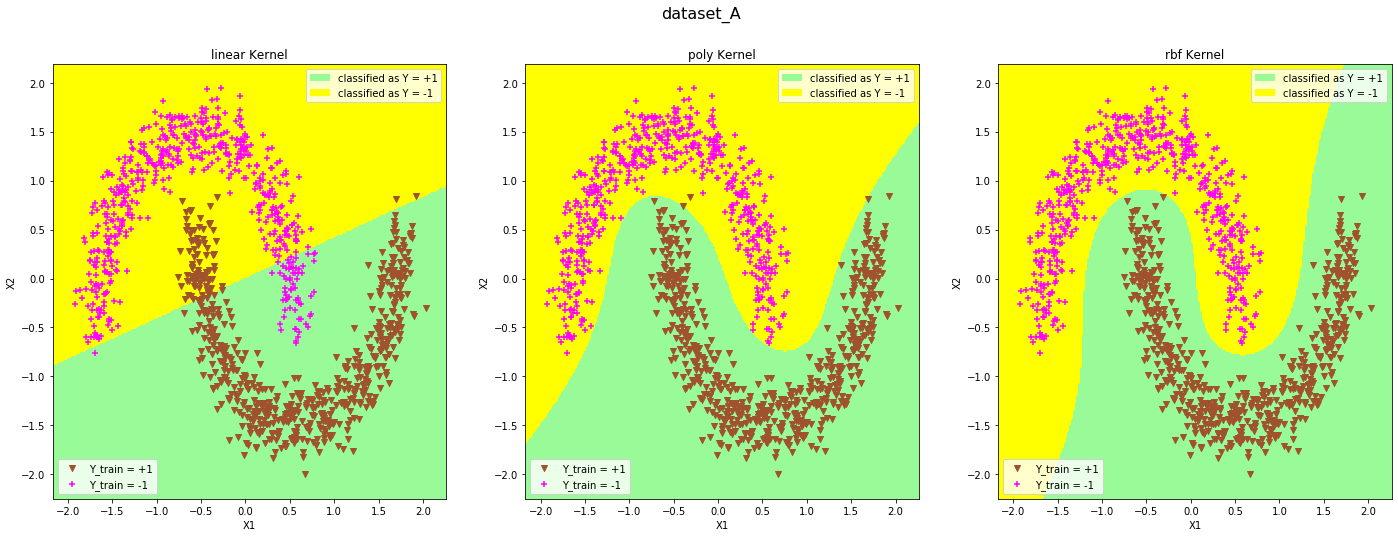

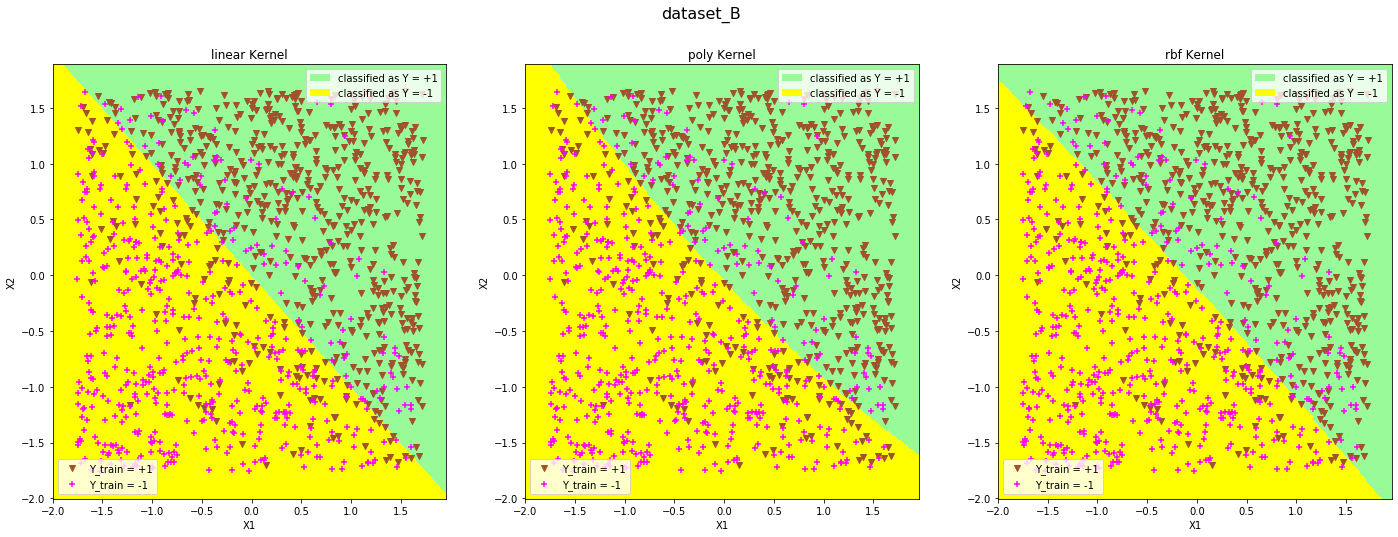

In [37]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6
for index in range(2):
    f, axs = plt.subplots(1, 3)
    axs = {'a': axs[0], 'b': axs[1], 'c': axs[2]}
    f.set_size_inches(24, 8, forward=True)
    f.suptitle('dataset_' + indtoa[index], fontsize=16)
    
    #xx, yy = np.meshgrid(np.arange(*axs['a'].get_xlim(), 0.05), np.arange(*axs['a'].get_ylim(), 0.05))
    # x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    # y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))  
    #X = np.c_[xx.ravel(), yy.ravel()]
    
    # n1=150
    # n2=150
    # x1=np.linspace(-1.5,2.5,n1)
    # x2=np.linspace(-1,1.5,n2)
    # x1,x2=np.meshgrid(x1,x2)
    # x1 = x1.reshape((n1*n2,1))
    # x2 = x2.reshape((n1*n2,1))
    # X = np.concatenate((x1,x2),axis=1)
    # X1 =x1.reshape((n1,n2))
    # X2 =x2.reshape((n1,n2))

    #xx, yy = np.meshgrid(np.arange(*axs['a'].get_xlim(), 0.1), np.arange(*axs['a'].get_ylim(), 0.1))
    mean = np.mean(X_train[index], axis = 0)
    X_train[index] = X_train[index] - mean
    std_dev = np.std(X_train[index], axis = 0)
    if std_dev.all() > 0:
      X_train[index] /= std_dev
    x_min, x_max = X_train[index][:, 0].min() - 0.25, X_train[index][:, 0].max() + 0.25
    y_min, y_max = X_train[index][:, 1].min() - 0.25, X_train[index][:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02)) 
    X = np.c_[xx.ravel(), yy.ravel()]     
    Y = {}

    ind = ['a', 'b', 'c']
    for i, ax in enumerate(axs.values()):  
        Y[i] = test_pred(alphas[(index,i)], X_train[index], Y_train[index], X, kernels[i], best_kernel_params[index][i]).reshape(xx.shape)
        a = ax.contourf(xx, yy, Y[i], colors=['yellow', 'palegreen'], levels = [-1,0,1])
        proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
        contour_legend = ax.legend(proxy[::-1], ["classified as Y = +1", "classified as Y = -1"] , loc= "upper right")
        ax.add_artist(contour_legend)
        ax.set_ylabel("X2")
        ax.set_xlabel("X1") 
        ax.set_title(f"{kernels[i]} Kernel") 
        X_train_positive = X_train[index][Y_train[index] == 1]
        X_train_negative = X_train[index][Y_train[index] == -1]
        ax.scatter(X_train_positive[:,0], X_train_positive[:,1], c='sienna', label='Y_train = +1', marker = 'v')
        ax.scatter(X_train_negative[:,0], X_train_negative[:,1], c='magenta', label='Y_train = -1',marker ='+')
        ax.legend(loc = "lower left")
         
#plt.legend(loc = "upper left")
plt.show()

# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [31]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here
def train_pred_svm(X, Y, kernel='linear', C=1., gamma=1., 
                                   degree=1., coef0=1):
  if kernel == 'poly':
    gamma, degree = degree, gamma
  #print(kernel, C, gamma)
  classif_algo =  svm.SVC(kernel = kernel, C=C, gamma=gamma, degree = degree, coef0 = coef0) # Play with different gamma and C and see changes
# k(u,v)=exp(-gamma*||u-v||**2)
  mean = np.mean(X, axis = 0)
  X = X - mean
  std_dev = np.std(X, axis = 0)
  if std_dev.all() > 0:
    X /= std_dev  
  classifier = classif_algo.fit(X,Y)
  return classifier


In [32]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.
Data_Path = '../../Data/'
indtoa = ['A', 'B', 'C', 'D']
X_train = dict()
Y_train = dict()
X_test  = dict()
Y_test  = dict()
X_valid = dict()
Y_valid = dict()
kernel_params = []
kernel_paramp = [1,2,2,3,4,5,6,7]
kernel_paramr = [1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 1e2]
reg_params = [1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 1e2]
kernels = ['linear', 'poly', 'rbf']
best_kernel_params = np.zeros((4,3))
best_reg_params = np.zeros((4,3))
train_error = np.zeros((4,3))
test_error = np.zeros((4,3))
train_frac = 0.8
psize = 8
classifiers = {}
for index in range(4):
  data = np.load(Data_Path + f"dataset_{indtoa[index]}.npz")
  lst = data.files
  X_train[index] = data[lst[0]]
  Y_train[index] = data[lst[1]]
  X_test[index] = data[lst[2]]
  Y_test[index] = data[lst[3]]
  n = X_train[index].shape[0]
  num_train = int(n*train_frac)
  X_valid[index] = X_train[index][num_train:]
  Y_valid[index] = Y_train[index][num_train:]
  X_train[index] = X_train[index][:num_train]
  Y_train[index] = Y_train[index][:num_train]
  mean = np.mean(X_train[index], axis = 0)
  X_train[index] = X_train[index] - mean
  X_valid[index] = X_valid[index] - mean
  X_test[index] = X_test[index] - mean
  std_dev = np.std(X_train[index], axis = 0)
  if std_dev.all() > 0:
    X_train[index] /= std_dev
    X_valid[index] /= std_dev
    X_test[index] /= std_dev

  for k, kernel in enumerate(kernels):
    if kernel == 'poly':
      kernel_params = kernel_paramp
    else: 
      kernel_params = kernel_paramr
    validation_error = np.zeros((psize,psize))
    for i, kernel_param in enumerate(kernel_params):
      for j, reg_param in enumerate(reg_params):
        classifier = train_pred_svm(X_train[index], Y_train[index], kernel, reg_param, kernel_param)
        Y_pred = np.sign(classifier.decision_function(X_valid[index]))
        validation_error[i][j] = np.sum(Y_pred != Y_valid[index])/Y_valid[index].shape[0]
    l,m = np.unravel_index(validation_error.argmin(), validation_error.shape)
    best_ker = kernel_params[l]
    best_reg = reg_params[m]
    classifier = train_pred_svm(X_train[index], Y_train[index], kernel, best_reg, best_ker)
    classifiers[(index,k)] = classifier
    Y_pred = np.sign(classifier.decision_function(X_train[index]))
    train_error[index][k] = np.sum(Y_pred != Y_train[index])/Y_train[index].shape[0]
    Y_pred = np.sign(classifier.decision_function(X_test[index]))
    test_error[index][k] = np.sum(Y_pred != Y_test[index])/Y_test[index].shape[0]
    best_kernel_params[index][k] = best_ker
    best_reg_params[index][k] = best_reg
    #print(indtoa[index], kernel)
    #print(validation_error)
print(train_error)
print(test_error)
print(best_kernel_params)
print(best_reg_params)

[[0.12666667 0.00083333 0.00083333]
 [0.17       0.17       0.16916667]
 [0.05583333 0.         0.        ]
 [0.06875    0.003125   0.04375   ]]
[[0.132      0.004      0.004     ]
 [0.196      0.196      0.196     ]
 [0.1043771  0.01346801 0.01683502]
 [0.0295858  0.01775148 0.01775148]]
[[1.e-07 3.e+00 1.e-01]
 [1.e-07 1.e+00 1.e-03]
 [1.e-07 3.e+00 1.e-03]
 [1.e-07 3.e+00 1.e-05]]
[[1.e+00 1.e-01 1.e+02]
 [1.e-01 1.e-01 1.e+02]
 [1.e+02 1.e-07 1.e+02]
 [1.e-03 1.e-03 1.e+02]]


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic). 

### Linear Kernel

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|:-----------:	|:----------:	|
|        A        	|    0.1267   	|   0.1320   	|
|        B        	|    0.1700   	|   0.1960   	|
|        C        	|    0.0558   	|   0.1044   	|
|        D        	|    0.0688   	|   0.0296   	|

### Polynomial Kernel

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|:-----------:	|:----------:	|
|        A        	|    0.0008   	|   0.0040   	|
|        B        	|    0.1700   	|   0.1960   	|
|        C        	|    0.0000   	|   0.0135   	|
|        D        	|    0.0312   	|   0.0178  	|

### RBF Kernel

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|:-----------:	|:----------:	|
|        A        	|    0.0008   	|   0.0040   	|
|        B        	|    0.1692   	|   0.1960   	|
|        C        	|    0.0000   	|   0.0168   	|
|        D        	|    0.0438   	|   0.0178   	|

### Best Regularisation Parameters

| Dataset \ Kernel 	|   Linear   	| Polynomial 	|    RBF    	|
|:----------------:	|:----------:	|:----------:	|:---------:	|
|         A        	|    1.000   	|    0.100   	|   100.0   	|
|         B        	|    0.100   	|    0.100   	|   100.0   	|
|         C        	|    100.0   	|    1.e-7   	|   100.0    	|
|         D        	|    0.001   	|    0.001   	|   100.0    	|

### Best Kernel Parameters

| Dataset \ Kernel 	| Polynomial 	|     RBF     	|
|:----------------:	|:----------:	|:-----------:	|
|         A        	|      3     	|     0.100    	|
|         B        	|      1     	|     0.001  	  |
|         C        	|      3     	|     0.001     |
|         D        	|      3     	|     1.e-5    	|

### Observations

<ol>
<li>We have standardised the datasets since the running time with standardisation was considerably less. This might be due to the data values being smaller and hence easier and stable computations. </li>
<li> On dataset A,the rbf and the polynomial kernels perform exceptionally well as they can easily generate the non-linear decision boundary. </li>
<li> All of the three kernels perform about the same on dataset B since the best we can achieve appears to be the diagonal seperating them. </li>
<li>Dataset C again appears to have a non-linear decision boundary where the rbf and polynomial kernels outperform the linear kernel. </li>
<li> Dataset D appears to be linearly seperable in the corresponding dimension as even the linear kernel achieves an accuracy of 97% </li>
<li> We observe that SVMs generally perform better than logistic regression on all datasets as the LIBSVM library uses advanced optimization algorithms and decomposition techniques compared to simple gradient descent that we have used. </li>
</ol>











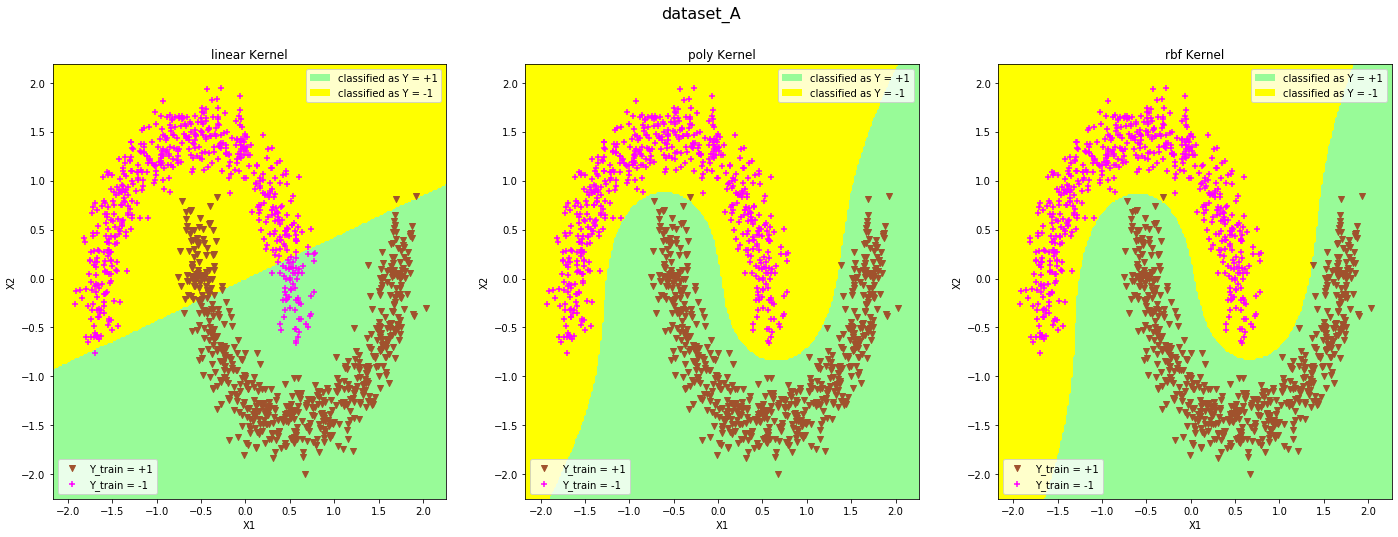

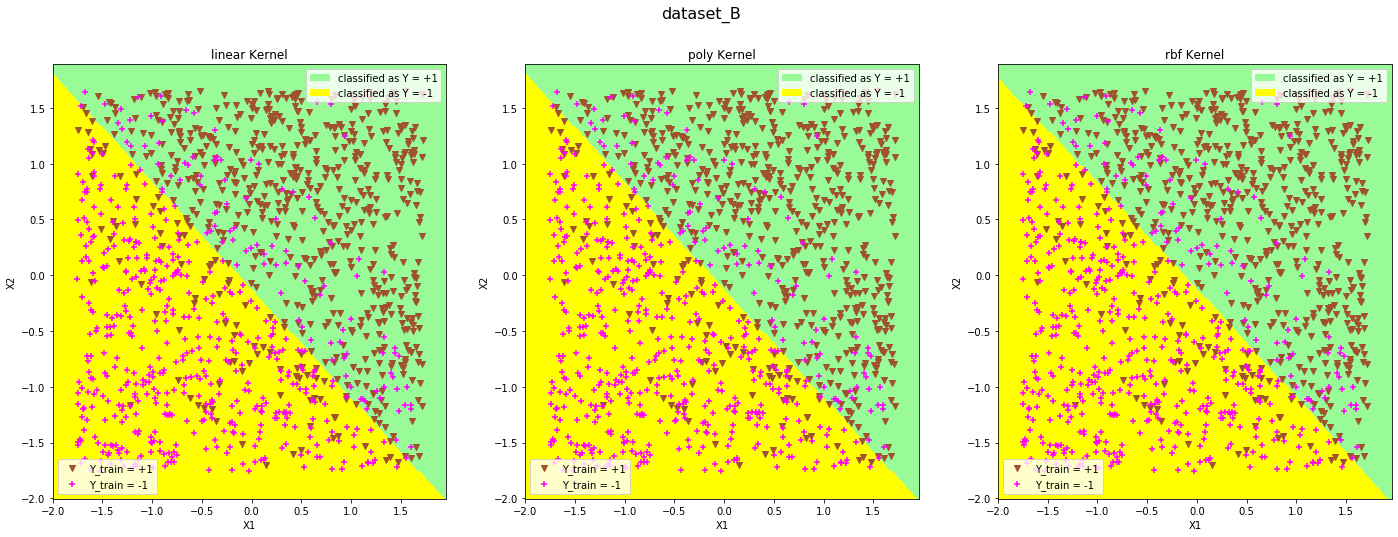

In [33]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6
for index in range(2):
    f, axs = plt.subplots(1, 3)
    axs = {'a': axs[0], 'b': axs[1], 'c': axs[2]}
    f.set_size_inches(24, 8, forward=True)
    f.suptitle('dataset_' + indtoa[index], fontsize=16)
    
    #xx, yy = np.meshgrid(np.arange(*axs['a'].get_xlim(), 0.05), np.arange(*axs['a'].get_ylim(), 0.05))
    # x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    # y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))  
    #X = np.c_[xx.ravel(), yy.ravel()]
    
    # n1=150
    # n2=150
    # x1=np.linspace(-1.5,2.5,n1)
    # x2=np.linspace(-1,1.5,n2)
    # x1,x2=np.meshgrid(x1,x2)
    # x1 = x1.reshape((n1*n2,1))
    # x2 = x2.reshape((n1*n2,1))
    # X = np.concatenate((x1,x2),axis=1)
    # X1 =x1.reshape((n1,n2))
    # X2 =x2.reshape((n1,n2))

    #xx, yy = np.meshgrid(np.arange(*axs['a'].get_xlim(), 0.1), np.arange(*axs['a'].get_ylim(), 0.1))
    mean = np.mean(X_train[index], axis = 0)
    X_train[index] = X_train[index] - mean
    std_dev = np.std(X_train[index], axis = 0)
    if std_dev.all() > 0:
      X_train[index] /= std_dev
    x_min, x_max = X_train[index][:, 0].min() - 0.25, X_train[index][:, 0].max() + 0.25
    y_min, y_max = X_train[index][:, 1].min() - 0.25, X_train[index][:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02)) 
    X = np.c_[xx.ravel(), yy.ravel()]     
    Y = {}

    ind = ['a', 'b', 'c']
    for i, ax in enumerate(axs.values()):  
        Y[i] = np.sign((classifiers[(index,i)].decision_function(X)).reshape(xx.shape))
        a = ax.contourf(xx, yy, Y[i], colors=['yellow', 'palegreen'], levels = [-1,0,1])
        proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
        contour_legend = ax.legend(proxy[::-1], ["classified as Y = +1", "classified as Y = -1"] , loc= "upper right")
        ax.add_artist(contour_legend)
        ax.set_ylabel("X2")
        ax.set_xlabel("X1") 
        ax.set_title(f"{kernels[i]} Kernel") 
        X_train_positive = X_train[index][Y_train[index] == 1]
        X_train_negative = X_train[index][Y_train[index] == -1]
        ax.scatter(X_train_positive[:,0], X_train_positive[:,1], c='sienna', label='Y_train = +1', marker = 'v')
        ax.scatter(X_train_negative[:,0], X_train_negative[:,1], c='magenta', label='Y_train = -1',marker ='+')
        ax.legend(loc = "lower left")
         
#plt.legend(loc = "upper left")
plt.show()





# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [23]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)
lpos = 0
lneg = 0
def h(x):
  if x in [0.,1.]:
    return 0
  return x*np.log(x) + (1-x)*np.log(1-x)

def accuracy(criterion, a, b, x, y):
  if criterion == 'accuracy':
    acc = (a+y-x)/(b+y)
    return max(acc, 1-acc)
  if criterion == 'entropy':
    pl = b/(b+y)
    t1 = pl * h(a/(b+1e-50))
    pr = 1 - pl
    t2 = pr * h (x/(y+1e-50))
    return t1 + t2
  assert False, "wrong criterion"

def split_node(tree, node_pos, X, Y, depth, num_nodes_stop=1, criterion = 'accuracy', depth_stop = 1e6):
  n = X.shape[0]
  total_pos = np.sum((Y == 1))
  total_neg = np.sum((Y == -1))
  global lpos, lneg
  if n <= num_nodes_stop or depth >= depth_stop or total_pos in [0, n] or ((lpos == total_pos) and (lneg == total_neg)):
    if total_pos > total_neg:
      class_pred = 1
    else:
      class_pred = -1
    tree[node_pos] = [-1,-1, class_pred]
    return

  lpos = total_pos
  lneg = total_neg
  best_dim = 0
  best_val = 0
  best_accuracy = -1e18  
  best_i = 0
  for d in range(X.shape[1]):
    ind = X[:,d].argsort()
    X = X[ind]
    Y = Y[ind]
    min_t = X[0][d]
    max_t = X[-1][d]
    npoints = 11
    step = (max_t - min_t)/npoints
    for j in range(1,npoints):
      thres = min_t + j*step
      num_pos_left = 0
      left = 0
      for i in range(n):
        if X[i][d] <= thres:
          left +=1
          if Y[i] > 0:
            num_pos_left += 1
      acc = accuracy(criterion, num_pos_left, left, total_pos - num_pos_left, n - left)
      if acc >= best_accuracy:
        best_accuracy = acc
        best_dim = d
        best_val = thres
  X_left = X[X[:, best_dim] <= best_val]
  Y_left = Y[X[:, best_dim] <= best_val]
  X_right = X[X[:, best_dim] > best_val]
  Y_right = Y[X[:, best_dim] > best_val]
  tree[node_pos] = [best_dim, best_val, 0]
  split_node(tree, 2*node_pos+1, X_left, Y_left, depth+1, num_nodes_stop, criterion, depth_stop)
  split_node(tree, 2*node_pos+2, X_right, Y_right, depth+1, num_nodes_stop, criterion, depth_stop)
  return


def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
  """ Returns a decision tree trained on X and Y. 
  Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
  Split criterion can be either 'accuracy' or 'entropy'.
  Returns a tree (In whatever format that you find appropriate)
  """
  tree = dict()
  tree[0] = [-1,-1, 1]
  split_node(tree, 0, X, Y, 0, num_nodes_stop, criterion)
  return tree
 
def eval(tree, node_pos, x):
  if tree[node_pos][0] == -1:
    return tree[node_pos][2]
  dim = tree[node_pos][0]
  val = tree[node_pos][1]
  if x[dim] <= val:
    return eval(tree, 2*node_pos+1, x)
  else:
    return eval(tree, 2*node_pos+2, x)

def eval_decision_tree(tree, test_X):
  """ Takes in a tree, and a bunch of instances X and 
  returns the tree predicted values at those instances."""
  n = test_X.shape[0]
  Y = np.zeros(n)
  for i in range(n):
    Y[i] = eval(tree, 0, test_X[i])
  return Y 






In [24]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.
Data_Path = '../../Data/'
indtoa = ['A', 'B', 'C', 'D']
X_train = dict()
Y_train = dict()
X_test  = dict()
Y_test  = dict()
X_valid = dict()
Y_valid = dict()
num_nodes_stops = [1,2,4,8,16,32,64]
criterions = ['accuracy', 'entropy']
best_num_nodes_stops = np.zeros((4,2))
train_error = np.zeros((4,2))
test_error = np.zeros((4,2))
train_frac = 0.80
psize = 7
trees = {}
for index in range(4):
  data = np.load(Data_Path + f"dataset_{indtoa[index]}.npz")
  lst = data.files
  X_train[index] = data[lst[0]]
  Y_train[index] = data[lst[1]]
  X_test[index] = data[lst[2]]
  Y_test[index] = data[lst[3]]
  n = X_train[index].shape[0]
  num_train = int(n*train_frac)
  X_valid[index] = X_train[index][num_train:]
  Y_valid[index] = Y_train[index][num_train:]
  X_train[index] = X_train[index][:num_train]
  Y_train[index] = Y_train[index][:num_train]
  for k, criterion in enumerate(criterions):
    validation_error = np.zeros(psize)
    for i, num_nodes_stop in enumerate(num_nodes_stops):
      tree = train_decision_tree(X_train[index], Y_train[index], num_nodes_stop, criterion)
      Y_pred = eval_decision_tree(tree, X_valid[index])
      validation_error[i] = np.sum(Y_pred != Y_valid[index])/Y_valid[index].shape[0]
    #l = psize - 1 - np.flip(validation_error).argmin()
    l = (validation_error).argmin()
    best_num_nodes_stop = num_nodes_stops[l]
    tree = train_decision_tree(X_train[index], Y_train[index], best_num_nodes_stop, criterion)
    trees[(index,k)] = tree
    Y_pred = eval_decision_tree(tree, X_train[index])
    #print(np.unique(Y_pred), np.unique(Y_train[index]))
    train_error[index][k] = np.sum(Y_pred != Y_train[index])/Y_train[index].shape[0]
    Y_pred = eval_decision_tree(tree, X_test[index])
    test_error[index][k] = np.sum(Y_pred != Y_test[index])/Y_test[index].shape[0]
    best_num_nodes_stops[index][k] = best_num_nodes_stop
    #print(indtoa[index], kernel)
    #print(validation_error)
print(train_error)
print(test_error)
print(best_num_nodes_stops)





[[0.015      0.0025    ]
 [0.18916667 0.17      ]
 [0.11083333 0.        ]
 [0.046875   0.        ]]
[[0.024      0.006     ]
 [0.218      0.2       ]
 [0.16835017 0.10774411]
 [0.0887574  0.0887574 ]]
[[ 4.  8.]
 [64. 64.]
 [32.  1.]
 [16.  1.]]


TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).

### Accuracy Criterion

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|-------------	|------------	|
|        A        	| 0.0150       	| 0.0240     	|
|        B        	| 0.1892      	| 0.2180     	|
|        C        	| 0.1108      	| 0.1684    	|
|        D        	| 0.0469      	| 0.0888    	|

### Entropy Criterion

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|-------------	|------------	|
|        A        	| 0.0025      	| 0.0060     	|
|        B        	| 0.1700       	| 0.2000     	|
|        C        	| 0.0000       	| 0.1077    	|
|        D        	| 0.0000       	| 0.0888     	|

### Best Node Stopping Size

| Dataset \Criterion| Accuracy 	| Entropy 	|
|:---------------:	|:--------:	|:-------:	|
|        A        	|     4    	|    8    	|
|        B        	|    64    	|    64   	|
|        C        	|    32    	|    1    	|
|        D        	|    16    	|    1    	|

### Observations

<ol>
<li>We observe that the entropy criterion consistency outperforms the accuracy criterion. The accuracy criterion has a discontinuous derivative, and this can
present problems when searching for an optimal decision over the search space. The entropy parameter being differentiable might provide better results when finding the optimal point.</li>
<li>We can see that B's number of nodes stop is higher compared to other. This means that the validation set should have been differing from the training set by a god extent. </li>
<li>We can see that training error is very less compared to test errors. This means that decision trees are prone to overfitting and are unstable classifiers, especially when the stopping node size is 1.</li>
<li>Dataset A seems to be simple to fit as by completely fitting the training set we have achieved more than $98\%$ accuracy, and the stopping node size is 1 for the both the criteria </li>
<li> Dataset C has the biggest difference of errors between accuracy and entropy criteria. In cases of equal accuracy splits, entropy helps to favour the split which results in more pure nodes. </li>
</ol>


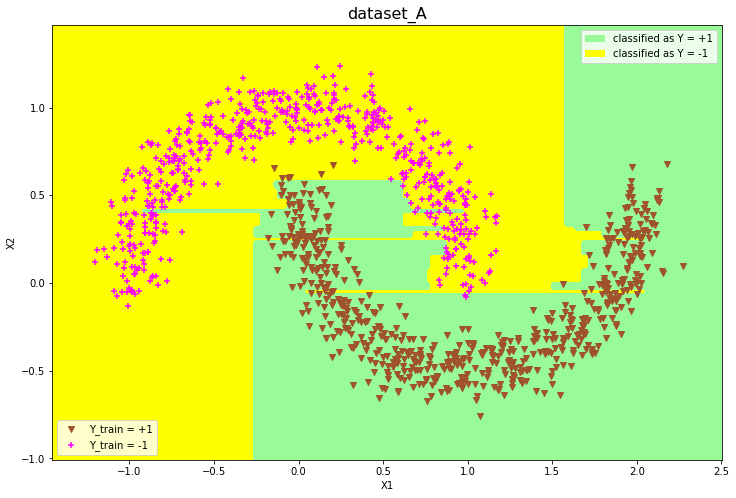

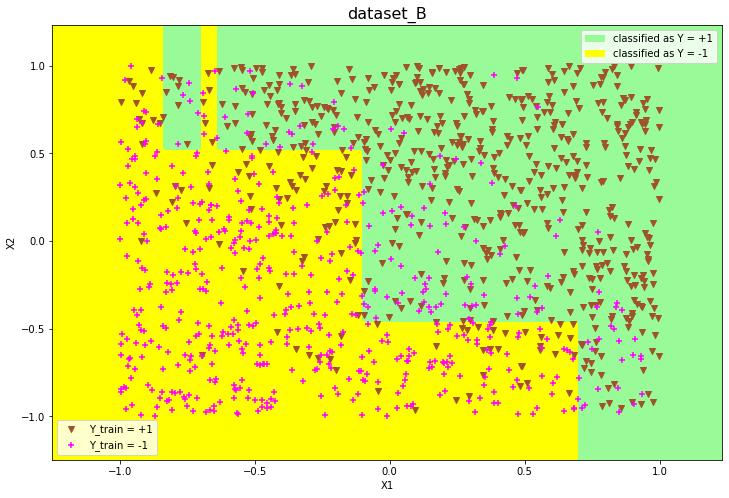

In [27]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 
for index in range(2):
    plt.figure()
    plt.gcf().set_size_inches(12, 8, forward=True)
    plt.title('dataset_' + indtoa[index], fontsize=16)
    x_min, x_max = X_train[index][:, 0].min() - 0.25, X_train[index][:, 0].max() + 0.25
    y_min, y_max = X_train[index][:, 1].min() - 0.25, X_train[index][:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02)) 
    X = np.c_[xx.ravel(), yy.ravel()]     
    Y = {}
    Y[0] = eval_decision_tree(trees[(index,0)], X).reshape(xx.shape)
    a = plt.contourf(xx, yy, Y[0], colors=['yellow', 'palegreen'], levels = [-1,0,1])
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    contour_legend = plt.legend(proxy[::-1], ["classified as Y = +1", "classified as Y = -1"] , loc= "upper right")
    plt.gca().add_artist(contour_legend)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1") 
    X_train_positive = X_train[index][Y_train[index] == 1]
    X_train_negative = X_train[index][Y_train[index] == -1]
    plt.scatter(X_train_positive[:,0], X_train_positive[:,1], c='sienna', label='Y_train = +1', marker = 'v')
    plt.scatter(X_train_negative[:,0], X_train_negative[:,1], c='magenta', label='Y_train = -1',marker ='+')
    plt.legend(loc = "lower left")
    plt.show()



# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [28]:
# CodeWrite cell
# Write Random Forest classifier.
lpos = 0
lneg = 0
def split_node_rf(tree, node_pos, X, Y, depth, num_nodes_stop=1, b = 0.5, criterion = 'accuracy', depth_stop = 1e6):
  n, dim = X.shape
  total_pos = np.sum((Y == 1))
  total_neg = np.sum((Y == -1))
  global lpos, lneg
  if n <= num_nodes_stop or depth >= depth_stop or total_pos in [0, n] or ((lpos == total_pos) and (lneg == total_neg)):
    if total_pos > total_neg:
      class_pred = 1
    else:
      class_pred = -1
    tree[node_pos] = [-1,-1, class_pred]
    return

  lpos = total_pos
  lneg = total_neg
  best_dim = 0
  best_val = 0
  best_accuracy = -1e18  
  best_i = 0
  attr = np.sort(np.random.choice(range(dim), int(dim*b), replace = False))
  #print(len(attr))
  for d in attr:
    ind = X[:,d].argsort()
    X = X[ind]
    Y = Y[ind]
    min_t = X[0][d]
    max_t = X[-1][d]
    npoints = 11
    step = (max_t - min_t)/npoints
    for j in range(1,npoints):
      thres = min_t + j*step
      num_pos_left = 0
      left = 0
      for i in range(n):
        if X[i][d] <= thres:
          left +=1
          if Y[i] > 0:
            num_pos_left += 1
      acc = accuracy(criterion, num_pos_left, left, total_pos - num_pos_left, n - left)
      if acc >= best_accuracy:
        best_accuracy = acc
        best_dim = d
        best_val = thres
  X_left = X[X[:, best_dim] <= best_val]
  Y_left = Y[X[:, best_dim] <= best_val]
  X_right = X[X[:, best_dim] > best_val]
  Y_right = Y[X[:, best_dim] > best_val]
  tree[node_pos] = [best_dim, best_val, 0]
  split_node_rf(tree, 2*node_pos+1, X_left, Y_left, depth+1, num_nodes_stop, b,criterion, depth_stop)
  split_node_rf(tree, 2*node_pos+2, X_right, Y_right, depth+1, num_nodes_stop, b, criterion, depth_stop)
  return


def train_decision_tree_rf(X, Y, num_nodes_stop=1, criterion='accuracy', b = 0.5):
  """ Returns a decision tree trained on X and Y. 
  Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
  Split criterion can be either 'accuracy' or 'entropy'.
  Returns a tree (In whatever format that you find appropriate)
  """
  tree = dict()
  tree[0] = [-1,-1, 1]
  split_node_rf(tree, 0, X, Y, 0, num_nodes_stop, b, criterion)
  return tree
 
def eval_rf(tree, node_pos, x):
  if tree[node_pos][0] == -1:
    return tree[node_pos][2]
  dim = tree[node_pos][0]
  val = tree[node_pos][1]
  if x[dim] <= val:
    return eval_rf(tree, 2*node_pos+1, x)
  else:
    return eval_rf(tree, 2*node_pos+2, x)

def eval_decision_tree_rf(tree, test_X):
  """ Takes in a tree, and a bunch of instances X and 
  returns the tree predicted values at those instances."""
  n = test_X.shape[0]
  Y = np.zeros(n)
  for i in range(n):
    Y[i] = eval_rf(tree, 0, test_X[i])
  return Y 

def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, 
                        criterion='accuracy', a=0.5, b=0.5):
  """ Returns a random forest trained on X and Y. 
  Trains num_trees.
  Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
  Split criterion can be either 'accuracy' or 'entropy'.
  Fraction of data used per tree = a
  Fraction of features used in each node = b
  Returns a random forest (In whatever format that you find appropriate)
  """
  n, dim = X.shape  
  forest = []
  for i in range(num_trees):
    samples = np.sort(np.random.choice(range(n), int(n*a), replace = False))
    forest.append(train_decision_tree_rf(X[samples], Y[samples], num_nodes_stop, criterion, b))
  return forest

def eval_random_forest(random_forest, test_X):
  """ Takes in a  random forest object (hhowever you want to store it), and a bunch of instances X and 
  returns the tree predicted values at those instances."""
  m, dim = test_X.shape
  Y = np.zeros(m)
  for tree in random_forest:
    Y = Y + eval_decision_tree_rf(tree, test_X)
  return np.sign(Y)


In [29]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.
Data_Path = '../../Data/'
indtoa = ['A', 'B', 'C', 'D']
X_train = dict()
Y_train = dict()
X_test  = dict()
Y_test  = dict()
X_valid = dict()
Y_valid = dict()
num_trees = []
num_trees_cd = [11,31,35,39,37,65,131,151]
num_trees_ab = [11,21,31,41,51,127,161,181]
criterions = ['accuracy', 'entropy']
best_num_trees = np.zeros((4,2))
train_error = np.zeros((4,2))
test_error = np.zeros((4,2))
train_frac = 0.80
psize = 8
forests = {}
for index in range(4):
  if index < 2:
    num_trees = num_trees_ab
  else:
    num_trees = num_trees_cd
  data = np.load(Data_Path + f"dataset_{indtoa[index]}.npz")
  lst = data.files
  X_train[index] = data[lst[0]]
  Y_train[index] = data[lst[1]]
  X_test[index] = data[lst[2]]
  Y_test[index] = data[lst[3]]
  n = X_train[index].shape[0]
  num_train = int(n*train_frac)
  #perm = np.random.permutation(n) - 1
  perm = np.arange(n)
  X_rand = X_train[index][perm]
  Y_rand = Y_train[index][perm]
  X_valid[index] = X_rand[num_train:]
  Y_valid[index] = Y_rand[num_train:]
  X_train[index] = X_rand[:num_train]
  Y_train[index] = Y_rand[:num_train]
  for k, criterion in enumerate(criterions):
    validation_error = np.zeros(psize)
    for i, num_tree in enumerate(num_trees):
      forest = train_random_forest(X_train[index], Y_train[index], num_tree, 1,criterion)
      Y_pred = eval_random_forest(forest, X_valid[index])
      validation_error[i] = np.sum(Y_pred != Y_valid[index])/Y_valid[index].shape[0]
    #l = psize - 1 - np.flip(validation_error).argmin()
    l = (validation_error).argmin()
    best_num_tree = num_trees[l]
    forest = train_random_forest(X_train[index], Y_train[index], best_num_tree, 1, criterion)
    forests[(index,k)] = forest
    Y_pred = eval_random_forest(forest, X_train[index])
    #print(np.unique(Y_pred), np.unique(Y_train[index]))
    train_error[index][k] = np.sum(Y_pred != Y_train[index])/Y_train[index].shape[0]
    Y_pred = eval_random_forest(forest, X_test[index])
    test_error[index][k] = np.sum(Y_pred != Y_test[index])/Y_test[index].shape[0]
    best_num_trees[index][k] = best_num_tree
    #print(indtoa[index], kernel)
    #print(validation_error)
print(train_error)
print(test_error)
print(best_num_trees)
# for i in range(50):
#   f1 = np.random.choice(250, 8, replace = False) + 1
#   f2 = np.random.choice(250, 8, replace = False) + 1
#   e(f1, f2)
# [[0.012      0.006     ]
# [0.196       0.196     ]
# [0.12121212  0.04713805]
# [0.04142012  0.02366864]]
# [[ 11.  21.]
#  [ 161.  31.]
#  [ 37. 131.]
#  [ 11. 151.]]

[[0.00166667 0.        ]
 [0.02083333 0.00916667]
 [0.07666667 0.00166667]
 [0.         0.00625   ]]
[[0.016      0.008     ]
 [0.202      0.206     ]
 [0.15488215 0.06060606]
 [0.03550296 0.0591716 ]]
[[ 31.  11.]
 [127. 127.]
 [ 11.  11.]
 [ 39.  35.]]


TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic). 

### Accuracy Criterion

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|-------------	|------------	|
|        A        	| 0.0000       	| 0.0120     	|
|        B        	| 0.0142      	| 0.1960     	|
|        C        	| 0.0700      	| 0.1212    	|
|        D        	| 0.0031      	| 0.0414    	|

### Entropy Criterion

| Dataset \ Error 	| Train Error 	| Test Error 	|
|:---------------:	|-------------	|------------	|
|        A        	| 0.0000      	| 0.0060     	|
|        B        	| 0.0192       	| 0.1960     	|
|        C        	| 0.0000       	| 0.0471    	|
|        D        	| 0.0062       	| 0.0237     	|

### Best Number of Trees

| Dataset \Criterion| Accuracy 	| Entropy 	|
|:---------------:	|:--------:	|:-------:	|
|        A        	|    11   	|    21    	|
|        B        	|    161   	|    31   	|
|        C        	|    37    	|    131    |
|        D        	|    11    	|    151   	|

### Observation

<ol>
<li> We observe that on an average, random forests perform better than decision trees </li>
<li>Dataset B has a very high difference between the train error and the test error. The number of trees is also very high, this means that there is significant overfitting. </li>
<li>In Dataset C, with the entropy criterion, there is a great reduction in test error (from $8.8\%$ to $2.4\%$) from decision tree to random forests, even though the train errors are comparable. This means that bagging and random selection has increased the generalizability of the classifier.</li>
<li> In Dataset D also we observe a similar trend with the entropy criterion.</li> 
<li> Training error is negligible on all datasets as we set the stopping node size as 1.</li>
</ol>


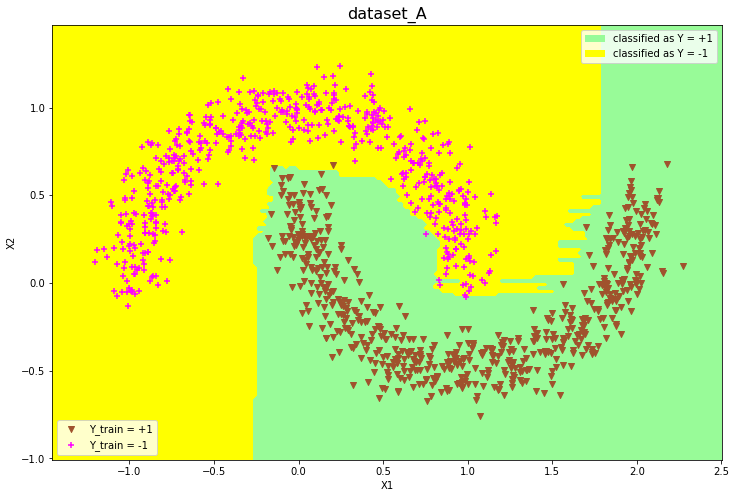

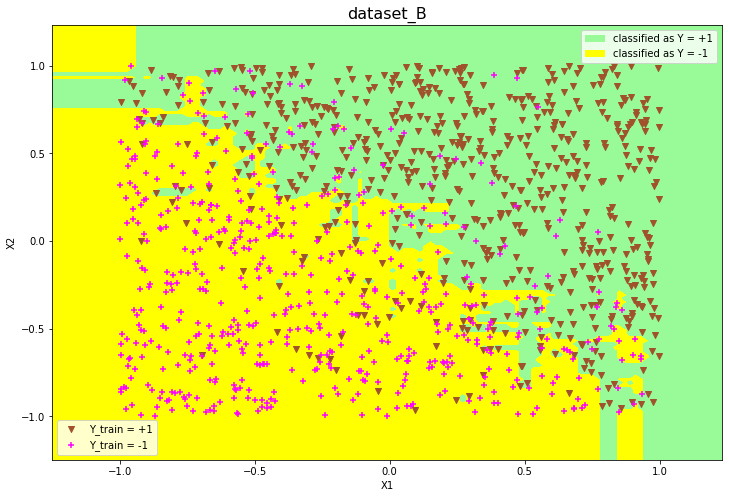

In [30]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 
for index in range(2):
    plt.figure()
    plt.gcf().set_size_inches(12, 8, forward=True)
    plt.title('dataset_' + indtoa[index], fontsize=16)
    x_min, x_max = X_train[index][:, 0].min() - 0.25, X_train[index][:, 0].max() + 0.25
    y_min, y_max = X_train[index][:, 1].min() - 0.25, X_train[index][:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02)) 
    X = np.c_[xx.ravel(), yy.ravel()]     
    Y = {}
    Y[0] = eval_random_forest(forests[(index,0)], X).reshape(xx.shape)
    a = plt.contourf(xx, yy, Y[0], colors=['yellow', 'palegreen'], levels = [-1,0,1])
    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
    contour_legend = plt.legend(proxy[::-1], ["classified as Y = +1", "classified as Y = -1"] , loc= "upper right")
    plt.gca().add_artist(contour_legend)
    plt.gca().set_ylabel("X2")
    plt.gca().set_xlabel("X1") 
    X_train_positive = X_train[index][Y_train[index] == 1]
    X_train_negative = X_train[index][Y_train[index] == -1]
    plt.scatter(X_train_positive[:,0], X_train_positive[:,1], c='sienna', label='Y_train = +1', marker = 'v')
    plt.scatter(X_train_negative[:,0], X_train_negative[:,1], c='magenta', label='Y_train = -1',marker ='+')
    plt.legend(loc = "lower left")
    plt.show()




# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs epochs. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [42]:
# Codewrite cell
# Write code to run here (no plotting)

lpos = 0
lneg = 0

def split_node_ab(tree, node_pos, X, Y, W , depth, num_nodes_stop=1, criterion = 'accuracy', depth_stop = 1e6):
  n = int(np.sum(W))
  total_pos = int(np.sum(W[(Y == 1)]))
  total_neg = int(np.sum(W[(Y == -1)]))
  global lpos, lneg
  if n <= num_nodes_stop or depth >= depth_stop or total_pos in [0, n] or ((lpos == total_pos) and (lneg == total_neg)):
    if total_pos > total_neg:
      class_pred = 1
    else:
      class_pred = -1
    tree[node_pos] = [-1,-1, class_pred]
    return

  lpos = total_pos
  lneg = total_neg
  best_dim = 0
  best_val = 0
  best_accuracy = -1e18  
  n_total = len(X)
  best_i = 0
  for d in range(X.shape[1]):
    ind = X[:,d].argsort()
    X = X[ind]
    Y = Y[ind]
    W = W[ind]
    min_t = X[0][d]
    max_t = X[-1][d]
    npoints = 11
    step = (max_t - min_t)/npoints
    for j in range(1,npoints):
      thres = min_t + j*step
      num_pos_left = 0
      left = 0
      for i in range(n_total):
        if X[i][d] <= thres:
          left += (W[i])
          if Y[i] > 0:
            num_pos_left += (W[i])
      acc = accuracy(criterion, num_pos_left, left, total_pos - num_pos_left, n - left)
      if acc >= best_accuracy:
        best_accuracy = acc
        best_dim = d
        best_val = thres
  ind = (X[:, best_dim] <= best_val)
  X_left = X[ind]
  Y_left = Y[ind]
  W_left = W[ind]
  ind = (X[:, best_dim] > best_val )
  X_right = X[ind]
  Y_right = Y[ind]
  W_right = W[ind]
  tree[node_pos] = [best_dim, best_val, 0]
  split_node_ab(tree, 2*node_pos+1, X_left, Y_left,W_left, depth+1, num_nodes_stop, criterion, depth_stop)
  split_node_ab(tree, 2*node_pos+2, X_right, Y_right,W_right, depth+1, num_nodes_stop, criterion, depth_stop)
  return


def train_decision_tree_withdepth(X, Y,W, depth_to_stop , criterion='accuracy'):
  """ Returns a decision tree trained on X and Y. 
  Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
  Split criterion can be either 'accuracy' or 'entropy'.
  Returns a tree (In whatever format that you find appropriate)
  """
  tree = dict()
  tree[0] = [-1,-1, 1]
  split_node_ab(tree, 0, X, Y,W, 0, 1 , criterion,depth_to_stop)
  return tree


def Weaklearner(trainX,trainY,testX,Weight,depth_to_stop) :
  tree = train_decision_tree_withdepth(trainX,trainY,Weight,depth_to_stop)
  ret = eval_decision_tree(tree,testX)
  return ret,tree



def adaboost(X,Y,depth_to_stop) :
  n = len(X)
  W = np.ones(n)
  beta = np.zeros(50)
  Learner = {}
  for i in range(50) :
    Y_pred,Learner[i] = Weaklearner(X,Y,X,W,depth_to_stop) #Weaklearner(trainX,trainY,testX)
    L = abs(Y-Y_pred)/2
    gamma = 1/2 - (W @ L.T)/(np.sum(W)+1e-50)
    beta[i] = (0.5 + gamma)/(0.5-gamma+1e-50)
    W = np.array([w*(beta[i]**int(L[j])) for j,w in enumerate(W) ])
    #print(gamma)

  return np.log(beta),Learner

def run_adaboost(beta,Learner,X_test) :
  m = len(X_test)
  n_iter_tot = len(Learner)
  ret_t = []
  for n_iter in range(n_iter_tot) :
    ret = np.zeros(m)
    for j in range(m) :
      Pred = np.array([eval(Learner[i],0,X_test[j]) for i in range(n_iter+1)])
      ret[j] = Pred @ beta[:n_iter+1].T
    ret = np.sign(ret)
    ret_t.append(ret)
  
  return ret_t

def run_adaboost_simple(beta,Learner,X_test) :
  m = len(X_test)
  n_iter = len(Learner)
  ret = np.zeros(m)
  for j in range(m) :
    Pred = np.array([eval(Learner[i],0,X_test[j]) for i in range(n_iter)])
    ret[j] = Pred @ beta[:n_iter+1].T
  ret = np.sign(ret)
  return ret



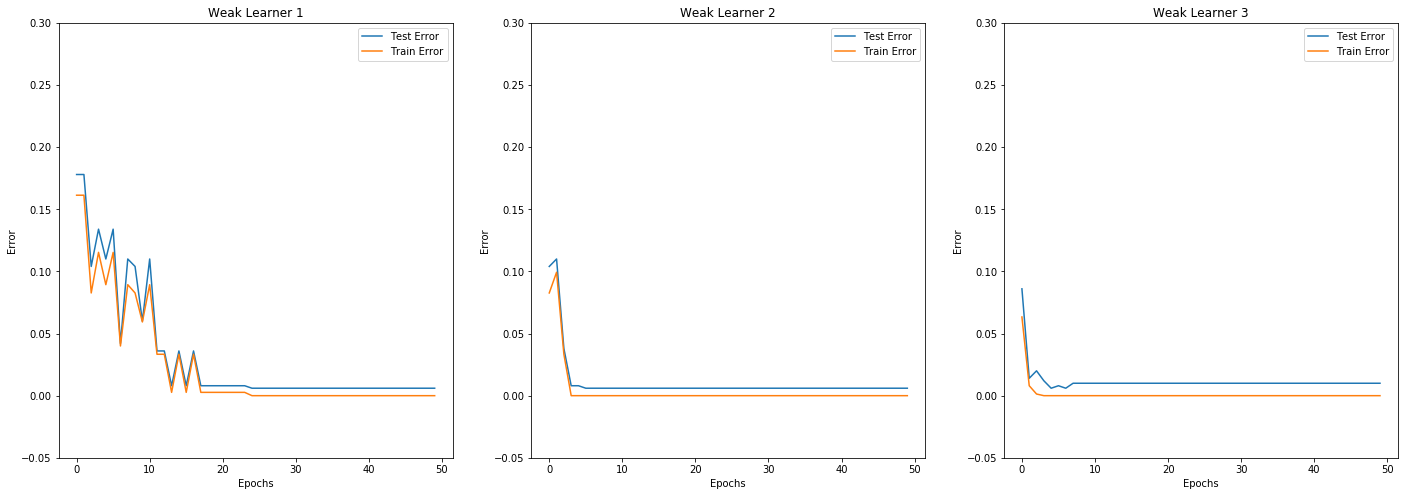

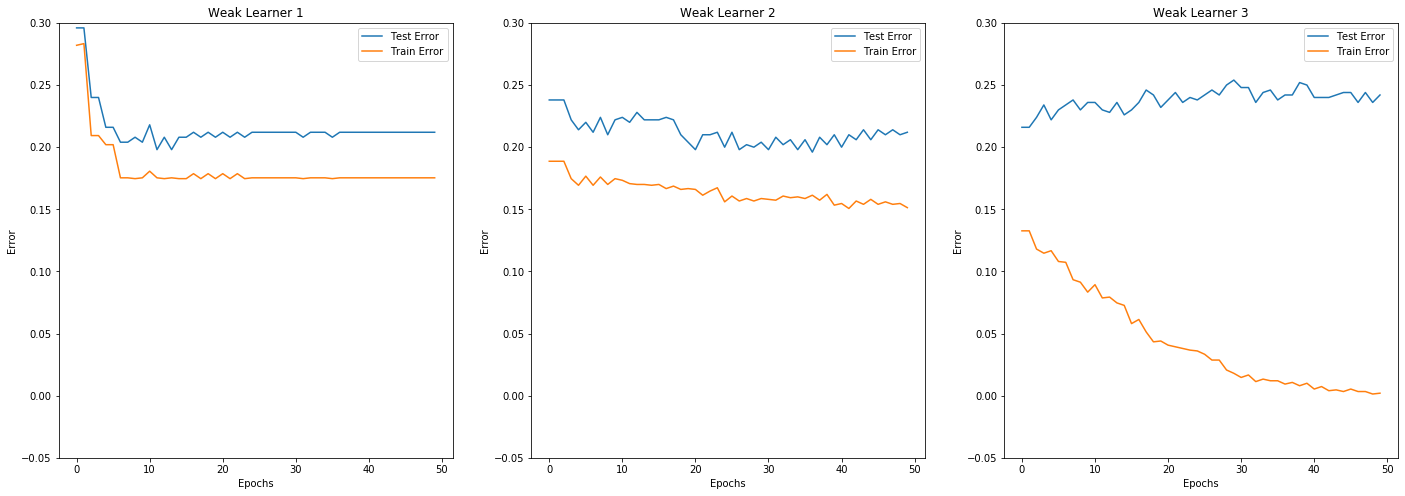

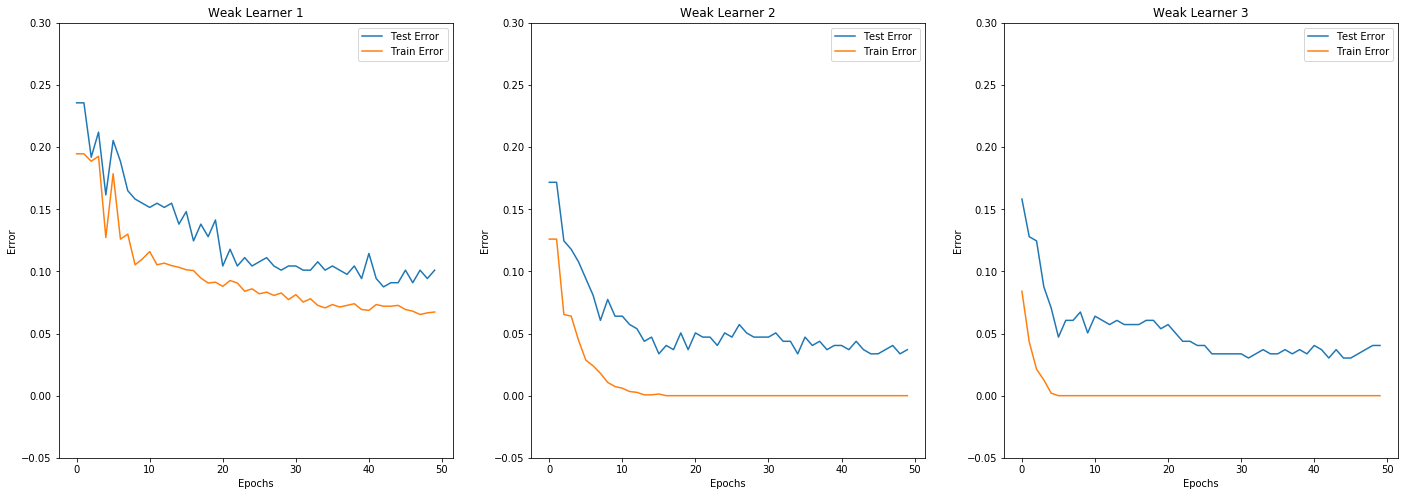

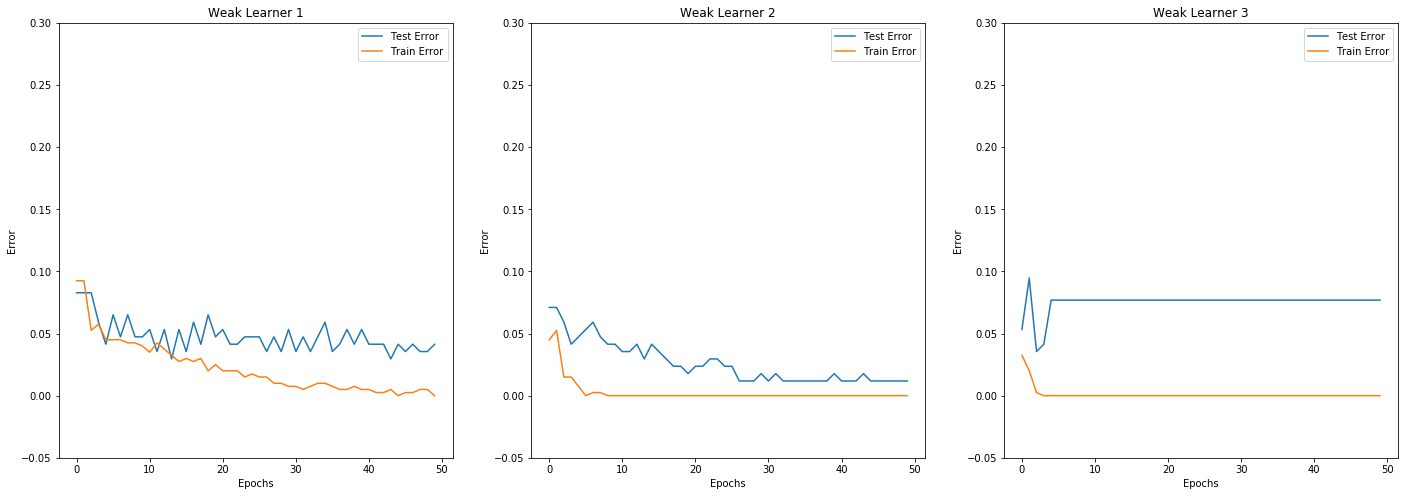

In [43]:
# Codewrite cell 
# Plots for iteration vs error here
Data_Path = '../../Data/'
indtoa = ['A', 'B', 'C', 'D']
X_train = dict()
Y_train = dict()
X_test  = dict()
Y_test  = dict()
train_error = np.zeros((4,3))
test_error = np.zeros((4,3))
train_errors = {} # train_errors[(i,j)] contains the list of train errors for each iteration in ith dataset, jth weak learner
test_errors = {} # test_errors[(i,j)] contains the list of test errors for each iteration in ith dataset, jth weak learner
learners = {} # learners[(i,j)] contains the list of learners for the ith dataset, jth weak learner
betas = {} # betas[(i,j)] contains the beta array for the ith dataset, jth weak learner
for index in range(4):
  data = np.load(Data_Path + f"dataset_{indtoa[index]}.npz")
  lst = data.files
  X_train[index] = data[lst[0]]
  Y_train[index] = data[lst[1]]
  X_test[index] = data[lst[2]]
  Y_test[index] = data[lst[3]]
  n = X_train[index].shape[0]
  plt.figure()
  plt.gcf().set_size_inches(24, 8, forward=True)
  plt.title('dataset_' + indtoa[index], fontsize=16)
  for k, depth in enumerate([1,3,7]):
    plt.subplot(1,3,k+1)
    plt.gca().set_title(f"Weak Learner {k+1}")
    plt.gca().set_ylim([-0.050,0.300])
    plt.gca().set_ylabel("Error")
    plt.gca().set_xlabel("Epochs")
    X_t=np.append(X_train[index],X_test[index],axis=0)
    betas[(index,k)],learners[(index,k)] = adaboost(X_train[index], Y_train[index],depth)
    Y_ret = run_adaboost(betas[(index,k)],learners[(index,k)],X_t)
    train_error_temp = []
    test_error_temp = []
    for Y_pred in Y_ret :
      Y_pred1 = Y_pred[:n]
      Y_pred2 = Y_pred[n:]
      val = np.sum(Y_pred1 != Y_train[index])/Y_train[index].shape[0]
      train_error_temp.append(val)
      val = np.sum(Y_pred2 != Y_test[index])/Y_test[index].shape[0]
      test_error_temp.append(val)
    x=[(i+1) for i in range(50)]
    plt.plot(np.array(test_error_temp), label = "Test Error")
    plt.plot(np.array(train_error_temp), label = "Train Error")
    train_errors[(index,k)] = train_error_temp
    test_errors[(index,k)] = test_error_temp
    plt.legend()
  plt.show()



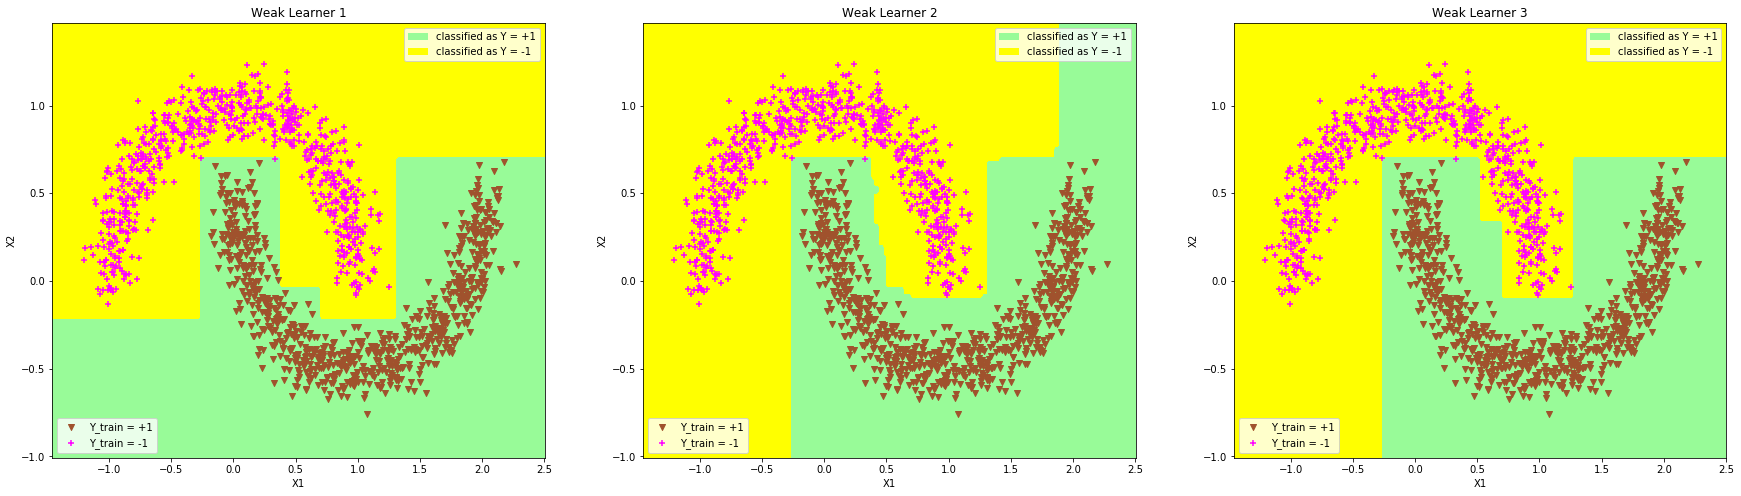

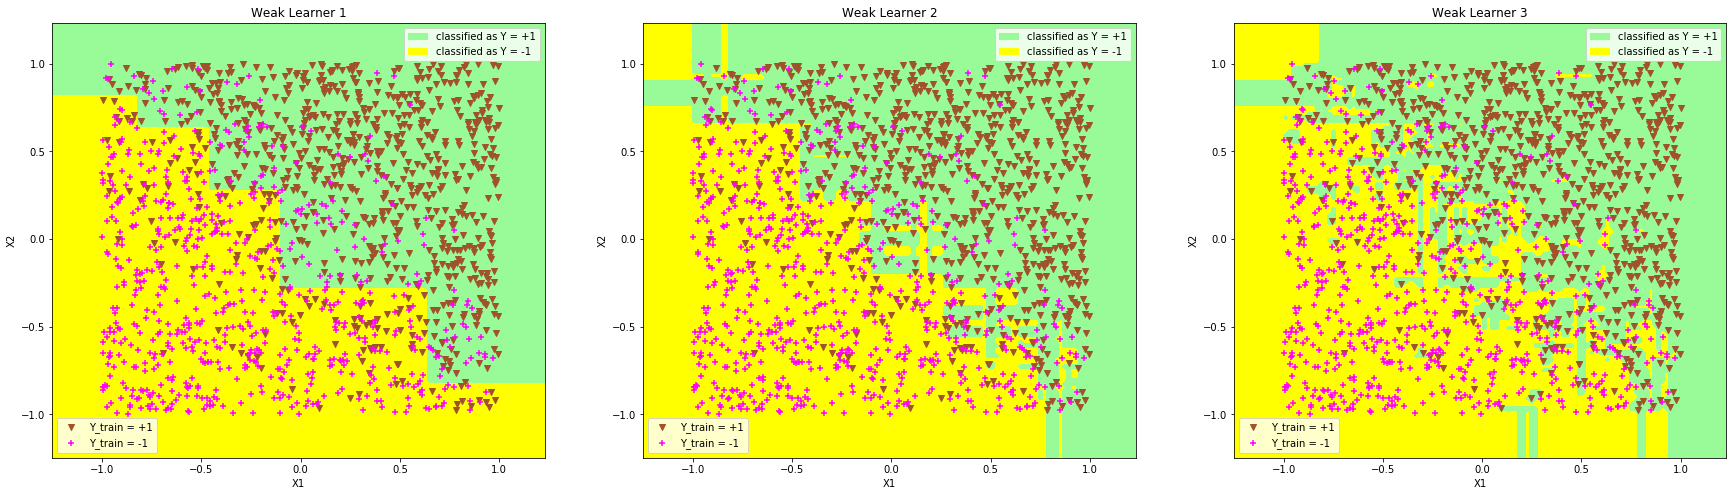

In [22]:
# Codewrite cell 
# Plots for illustrating the classifier here
# Codewrite cell 
# Plots for illustrating the classifier here
for index in range(2):
    plt.figure()
    plt.gcf().set_size_inches(30, 8, forward=True)
    plt.title('dataset_' + indtoa[index], fontsize=16)
    for j,depth in enumerate([1,3,7]) :
      plt.subplot(1,3,j+1)
      plt.gca().set_title(f"Weak Learner {j+1}")
      x_min, x_max = X_train[index][:, 0].min() - 0.25, X_train[index][:, 0].max() + 0.25
      y_min, y_max = X_train[index][:, 1].min() - 0.25, X_train[index][:, 1].max() + 0.25
      xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02)) 
      X = np.c_[xx.ravel(), yy.ravel()]     
      Y = run_adaboost_simple(betas[(index,j)],learners[(index,j)], X).reshape(xx.shape)
      a = plt.contourf(xx, yy, Y, colors=['yellow', 'palegreen'], levels = [-1,0,1])
      proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in a.collections]
      contour_legend = plt.legend(proxy[::-1], ["classified as Y = +1", "classified as Y = -1"] , loc= "upper right")
      plt.gca().add_artist(contour_legend)
      plt.gca().set_ylabel("X2")
      plt.gca().set_xlabel("X1") 
      X_train_positive = X_train[index][Y_train[index] == 1]
      X_train_negative = X_train[index][Y_train[index] == -1]
      plt.scatter(X_train_positive[:,0], X_train_positive[:,1], c='sienna', label='Y_train = +1', marker = 'v')
      plt.scatter(X_train_negative[:,0], X_train_negative[:,1], c='magenta', label='Y_train = -1',marker ='+')
      plt.legend(loc = "lower left")
    plt.show()



Textwrite cell:
### Observations

<ol>
<li>We can observe that in datasets A,C and D the errors are comparable to the ones obtained from random forests.</li>
<li>We can see from the error v/s epochs plot that after few iterations even a seemingly simple classifier such as the one node decision tree can be boosted to get a performance equivalent to that of random forests.</li>
<li>From the plots we can see that weak learner $1$ (with depth $1$) gives relatively simple  decision boundaries whereas weak learner $3$ (with depth $7$ ) gives extremely complicated boundaries.</li>
<li>For many learners, the errors remain almost constant after 10 iterations.</li>
<li>In dataset B, we can see that $7$ node decision tree only decreases the train error, but test error is still high. This can be because of overfitting, and in this case, $1$ node decision tree has better performance on test data.</li>
<li>Higher depth leads to faster convergence while training.</li>
</ol>